In [1]:
import mdtraj as md
import matplotlib.pyplot as plt
from numpy import dot
import nglview as nv
import numpy as np

# https://biopython.org/docs/1.74/api/Bio.SVDSuperimposer.html
from Bio.SVDSuperimposer import SVDSuperimposer

# Load H-NS dimers
loc_dimers = './data/dimer_pdbs/'
dimers = md.join([md.load(loc_dimers+f'run{i}.pdb') for i in range(0,16)])

# Load site2 - site2 data
loc_site = './data/'
site2_complex = md.load(loc_site+f'site2-dimer-LAA.pdb')
# site2_complex = md.load(loc_site+f'site21.pdb')


In [89]:
s1s1 = dimers[3]
s2s2 = site2_complex

# s2s2 does not contain hydrogens so also remove them from s1s1
s1s1 = s1s1.atom_slice(s1s1.top.select('not element H'))

# indices are the same in s1s1 and s2s2, so selection can be identical
selection = s1s1.top.select('resid 53 to 79')

In [90]:
view = nv.show_mdtraj(s1s1)
view.add_representation('licorice',selection)
view


NGLWidget()

In [91]:
view = nv.show_mdtraj(s2s2)
view.add_representation('licorice',selection)
view

NGLWidget()

In [92]:
# Extract xyz coordinates of first frame complex and idx dimer
xyz_A = s1s1.xyz[0].T
xyz_B = s2s2.xyz[0].T

atom_set_A = s1s1.atom_slice(selection).xyz[0].T
atom_set_B = s2s2.atom_slice(selection).xyz[0].T

# load super imposer
sup = SVDSuperimposer()

# Set the coords y will be rotated and translated on x
x = atom_set_A.T
y = atom_set_B.T
sup.set(x, y)

# Do the lsq fit
sup.run()

# Get the rms
rms = sup.get_rms()

# Get rotation (right multiplying!) and the translation
rot, tran = sup.get_rotran()

# Rotate y on x
y_on_x1 = dot(y, rot) + tran

# Same thing
y_on_x2 = sup.get_transformed()

print('rms',"%.2f" % rms)

rms 0.62


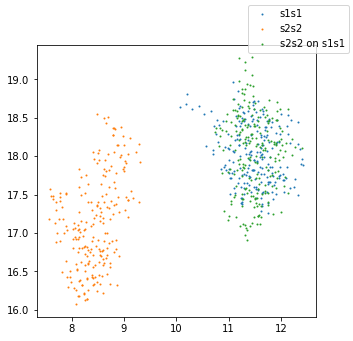

In [93]:
fig,ax=plt.subplots(figsize=[5,5])
ax.scatter(atom_set_A[2],atom_set_A[1],s=1,label='s1s1')
ax.scatter(atom_set_B[2],atom_set_B[1],s=1,label='s2s2')
ax.scatter(y_on_x2.T[2],y_on_x2.T[1],s=1,label='s2s2 on s1s1')
fig.legend()

In [94]:
a = xyz_A.T
b = xyz_B.T

# rotate b on a
b_on_a1 = dot(b, rot) + tran

# replace coordinates 
s2s2.xyz[0] = b_on_a1

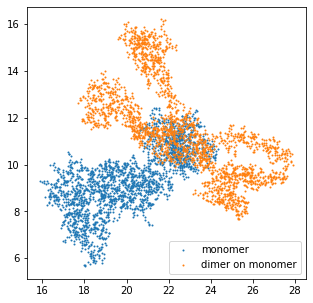

In [95]:

fig,ax=plt.subplots(figsize=[5,5])
i = 0
j = 2
ax.scatter(xyz_A[i],xyz_A[j],s=1,label='monomer')
#ax.scatter(xyz_B[i],xyz_B[j],s=1,label='dimer')
ax.scatter(b_on_a1.T[i],b_on_a1.T[j],s=1,label='dimer on monomer')
ax.legend()



In [98]:
# make new frame with fitted dimer and DNA, aka merge complex and dimer and remove monomer
test = s1s1.stack(s2s2)
view = nv.show_mdtraj(test)
view

NGLWidget()

In [97]:
selection = [at.index for idx,chain in enumerate(test.top.chains) if idx != 2 for at in chain.atoms]
# probably easiest to use atomslice to remove/delete monomer
final = test.atom_slice(selection)
# show = [at.index for at in final.top._chains[2].atoms]
view = nv.show_mdtraj(final)
# view.add_licorice(selection=show)
view

NGLWidget()

In [8]:
# Extract xyz coordinates of chosen frame for complex and dimer
def extract_coords(traj):
    return traj.xyz[0].T

# Get indices of atoms to fit, in this case only the last 48 residues, which coincide with the DBD
def get_index(molecule, chain_idx, atoms):
    return [at.index for res in molecule.top._chains[chain_idx]._residues[-atoms:] for at in res.atoms]

def slice_transpose(molecule,molecule_idx):
    return molecule.atom_slice(molecule_idx).xyz[0].T

def superimpose(coords_a, coords_b):
    sup = SVDSuperimposer()

    # Set the coords y will be rotated and translated on x
    x = coords_a.T
    y = coords_b.T
    sup.set(x, y)

    # Do the lsq fit
    sup.run()

    # Get the rms
    rms = sup.get_rms()

    # Get rotation (right multiplying!) and the translation
    rot, tran = sup.get_rotran()

    # Rotate y on x
    y_on_x1 = dot(y, rot) + tran

    # Same thing
    y_on_x2 = sup.get_transformed()
    
    return rms, rot, tran

In [9]:
def fit(struct_a, struct_b, fit_idx_a, fit_idx_b):
    
    # van fit selection een lijst van indeces
    xyz_a = extract_coords(struct_a)
    xyz_b = extract_coords(struct_b)
    
    atom_set_a = slice_transpose(struct_a, fit_idx_a)
    atom_set_b = slice_transpose(struct_b, fit_idx_b)
    
    rms, rot, tran = superimpose(atom_set_a, atom_set_b)
    
    a = xyz_a.T
    b = xyz_b.T

    # rotate b on a
    b_on_a1 = dot(b, rot) + tran

    # replace coordinates 
    struct_a.xyz = b_on_a1
    
    fitted = struct_b.stack(struct_a)
    
    selection = [at.index for idx,chain in enumerate(fitted.top.chains) if idx != 2 for at in chain.atoms]
    # probably easiest to use atomslice to remove/delete monomer
    final = fitted.atom_slice(selection)
    
    # return final
    return final, rms

In [10]:
#resid 53 - 79 = atom 849 - 1295

test, rms = fit(traj, dimers[7], idx, idx)

view = nv.show_mdtraj(test)
view

ValueError: xyz must be shape (Any, 2174, 3). You supplied  (1, 4390, 3)

array([ 849,  850,  851,  852,  853,  854,  855,  856,  857,  858,  859,
        860,  861,  862,  863,  864,  865,  866,  867,  868,  869,  870,
        871,  872,  873,  874,  875,  876,  877,  878,  879,  880,  881,
        882,  883,  884,  885,  886,  887,  888,  889,  890,  891,  892,
        893,  894,  895,  896,  897,  898,  899,  900,  901,  902,  903,
        904,  905,  906,  907,  908,  909,  910,  911,  912,  913,  914,
        915,  916,  917,  918,  919,  920,  921,  922,  923,  924,  925,
        926,  927,  928,  929,  930,  931,  932,  933,  934,  935,  936,
        937,  938,  939,  940,  941,  942,  943,  944,  945,  946,  947,
        948,  949,  950,  951,  952,  953,  954,  955,  956,  957,  958,
        959,  960,  961,  962,  963,  964,  965,  966,  967,  968,  969,
        970,  971,  972,  973,  974,  975,  976,  977,  978,  979,  980,
        981,  982,  983,  984,  985,  986,  987,  988,  989,  990,  991,
        992,  993,  994,  995,  996,  997,  998,  9